# NLP Assignment 3
Created by Prof. [Mohammad M. Ghassemi](https://ghassemi.xyz)

Submitted by: <span style="color:red"> INSERT YOUR NAME HERE </span>

In collaboration with: <span style="color:red"> INSERT YOUR (OPTIONAL) HOMEWORK PARTNER'S NAME HERE </span>


<hr> 

In [1]:
import importlib
from materials.code import utils
importlib.reload(utils)

# IMPORT SOME BASIC TOOLS:
from pprint import pprint
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import json

[nltk_data] Downloading package punkt to /Users/ghamut/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ghamut/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<hr>

# Part 3: Neural Networks



In the previous section, we wrote a `sigmoid` function that took a given value of `x`, `b` and `m`, to generate a single evaluation of the sigmoid function. But our previous implementation was certainly not the most flexible or generalizable way to write a sigmoid if we want to use it for general purpose machine learning tasks. So, let's begin this section by rewriting this sigmoid so that it's more compact and flexible:

In [3]:
#------------------------------------------------------
# A more general purpose signmoid
#------------------------------------------------------
def sigmoid(beta, X):
    lin = np.dot(X, beta[1:]) + beta[0]
    return 1/(1 + np.exp(-(lin)))

<br><br> This new `sigmoid` function is more flexible because it allows us to pass an entire data matrix $X$ with $m$ rows and $n$ columns, and a set of $n+1$ paramters ($\beta_{i:n+1}$) and will return the result of the simoid applied to each of the $m$ rows in $X$. Note that in the above implmentation $\beta_0$ is assumed to be the intercept term in the linear equation.

### Stacking sigmoids for enhanced flexibility
A simple sigmoid is a decent model when we can assume that there is a monotonic relationship between our input and output variables. Take the general relationship between height and age for instance; it's safe to assume ( for the most part ), that a one unit increase in age will always have a positive effect on height. Obviously, the magnitude of that positive effect will be larger for a teenager than for an adult, but it's still fair to make the assumption that the relationship will always be always positive.

There are many kinds of modeling problems, however, where the relationship between the input and the output is clearly not monotonic. Consider for instance, if I wanted to predict your mood (good or bad), given the number of pizza slices you've consumed for your lunch. For a one unit increase in pizza, the probability of your mood being good would probably increase but only up until you become full. After that, a one unit increase in the pizza consumption would decrease the probability of your mood being good (and might require some Pepto Bismol as well). A simple logistic regression is not capable of modeling this more nuanced kind of relationship. We can tune the paramters as much as we want, but the model will always look like a sigmoid! 

One path we could take to solve the pizza-mood problem it to write out a brand new model. But what might this model look like? It will definetly need sigmoid-like properties because there will need to be some areas where it increases, some other areas where it decreases and yet other areas where it is flat. So, one sensible thing to try might be a linear combination of sigmoids (a weighted average, for instance):

$$\hat{y} = w_0 + w_1\sigma_1(x) + w_2\sigma_2(x) $$

Where the $w$ terms refer to the weight we'll apply when combining the sigmoids, and the $\sigma(x)$ is just shorthand for the sigmoid equation. The only problem with this form is that we'll have to be careful about how we set those weights ($w_{0:2}$) or the predicted value of $\hat{y}$ could fall outside the range of 0 and 1. How can we solve this? If only we had some mathematical function that could constrain the values between 0 and 1... like **another sigmoid**:

$$\hat{y} = \sigma(w_0 + w_1\sigma_1(x) + w_2\sigma_2(x))$$

Let's try it out with some random values of $w$ and $\beta$ to see if we get any shapes that look feasible for the pizza-mood problem:

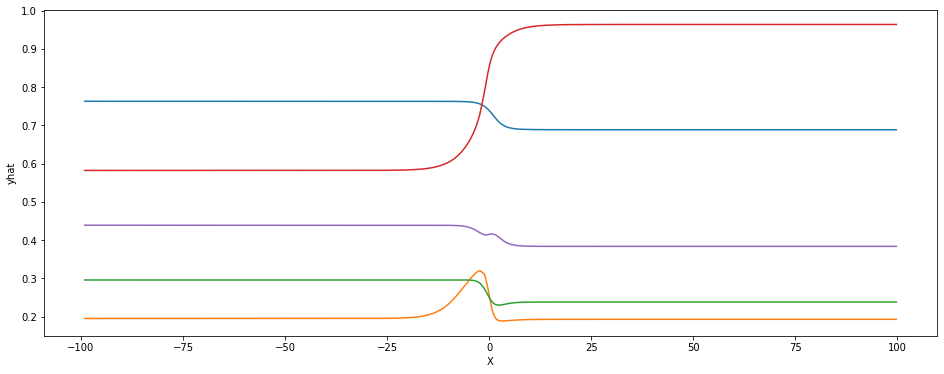

In [207]:
plt.figure(figsize = (16,6))

# Initialize some random value for some data X and paramters beta
X  = np.random.uniform(low= -100, high = 100, size = (1000,1))

# For 5 random models
for x in range(5):
    # For some random values of betas
    beta1  = np.random.normal(size = (np.shape(X)[1] + 1,1))
    beta2  = np.random.normal(size = (np.shape(X)[1] + 1,1))

    # Pack the sigmoids into a new `X` 
    X2  = np.concatenate((sigmoid(beta1 ,X),
                          sigmoid(beta2 ,X)),axis=1)
      
    # For some random values of w, create yhat.
    num_ws = np.shape(X2)[1] + 1
    ws     = np.random.normal(size = (np.shape(X2)[1] + 1,1))
    yhat   = sigmoid(ws ,X2) 
    
    # Print it
    index  = np.argsort(X[:,0])
    X      = X[index,:]; 
    yhat   = yhat[index,:]
    plt.plot(X,yhat)
    plt.xlabel('X');plt.ylabel('yhat')
plt.show()


<br><br>With a litte bit of tuning (through gradient descent perhaps) that orange line looks like it might work for the pizza-mood problem we mentioned earlier! Furthermore, it looks like there are a bunch of other shapes that are possible when we take a sigmoid of other sigmoids.

### Training Models Using PyTorch

In the previous section, we observed that two **layers** of sigmoids (*sigmoid of sigmoids*) provided a more flexible way to model the relationship between $X$ and $y$; but even so, one might feel that the lines were still too rigid. What if we want them to be even more flexible? Well, if two layers of sigmoids (*a sigmoid of sigmoids*) provided some flexibility, it stands to reason that three layers (*a sigmoid of sigmoids of sigmoids*) would be even more flexible! Furthermore, we do not have to limit ourselves to using just two sigmoids **nodes** per-layer, we could add more nodes too. It definetly feels like these models could, with enough layers and nodes, approximate any relationship between $X$ and $y$. Such a "smart" method needs a smart name - let's call them **neural networks**. 

Now that we understand how to build a Neural Network from scratch, let's work on getting some practical experience building Neural Networks with existing toolkits. There are two popular python packages for most neural network purposes: [Keras](https://keras.io/), and [PyTorch](https://pytorch.org/). The two packages support simmilar functionality, but PyTorch is a little easier to learn if you're a beginner (or so I'm told). Let's begin by importing Pytorch.

In [2]:
import torch

Neural Network Libraries like Pytorch provide a variety of tools to help us more build existing and novel neural networks from the ground-up. For instance, we can use `torch` to easilly compute gradients of functions:

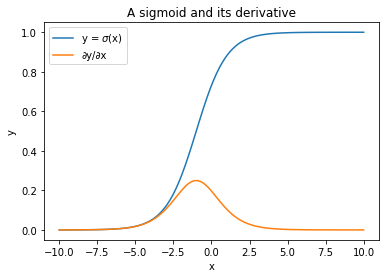

In [3]:
grad, xnp, ynp = [], [],[]

#------------------------------------------------
# Initialize some paramters of a model
#------------------------------------------------
b1 =  torch.tensor(1.0, requires_grad=True)
m1 =  torch.tensor(1.0, requires_grad=True)

#------------------------------------------------
# For some various values of x
#------------------------------------------------
X = np.linspace(-10,10,100)
for x in X:
    #------------------------------------------------
    # Convert x into a torch tensor
    #------------------------------------------------
    x =  torch.tensor(x, requires_grad=True)

    #------------------------------------------------
    # compute y using x and the paramters m1,m2,b1,b2
    #------------------------------------------------
    y =  1 / (1 + torch.exp(-(m1*x+b1)))
    
    #------------------------------------------------
    # calculate the gradient in y with respect to x
    # using the back-propagation algorithm
    #------------------------------------------------
    y.backward()  # ∂y/∂x = 2   

    #------------------------------------------------
    # Store the gradients
    #------------------------------------------------    
    grad.append( x.grad.numpy() )
    xnp.append( x.detach().numpy() )
    ynp.append( y.detach().numpy() )
    

#------------------------------------------------
# Plot the results
#------------------------------------------------   
plt.plot(xnp , ynp , label='y = $\sigma$(x)')
plt.plot(xnp ,grad, label='∂y/∂x')
plt.title('A sigmoid and its derivative')   
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

<br><br> In the code block above, the `y.backward()` computes the gradient in `y`, with respect to the paramters (`m1`,`b1`), and our input `x` using a technique called [back-propogation](https://www.youtube.com/watch?v=Ilg3gGewQ5U&ab_channel=3Blue1Brown). As you may recall from earlier in the tutorial, once we have the gradients of a loss function with respect to some paramters, we can go about optimizing those paramters!  If you've understood everything we've done in the tutorial up to this point the syntax of `torch` will be relatively straight forward; let's look at an examples:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import grad
torch.set_grad_enabled(True)

<br><br>First, let's recreate the logistic regression model in Pytorch notation:

In [5]:
#------------------------------------------------
# Define a Model
#------------------------------------------------
class LogisticRegression(nn.Module): 
    
    #------------------------------------------------
    # Torch Requires an init function where the
    # paramters of the model are specified
    #------------------------------------------------
    def __init__(self, n_inputs, n_outputs):
        
        # This line calls the init function of "nn.Module"; 
        # you must always do this in any "nn.Module"
        super(LogisticRegression, self).__init__()
        
        # Indicates that our model paramters are a 
        # linear function that maps n inputs to n_outputs
        self.linear  = nn.Linear(n_inputs, n_outputs)
        
    #------------------------------------------------
    # Torch also Requires an forward function that specifies 
    # what to do with the output (e.g. apply a sigmoid).
    #------------------------------------------------
    def forward(self, x):
        
        # Indicates that we must pass the linear component of the 
        # model (mx + b ) through a sigmoid before returning the results
        return torch.sigmoid( self.linear(x) )

<br><br>We'll also want a way to `train` and `evaluate` our model; these don't come standard with Pytorch, so I've written them below:

In [6]:
#------------------------------------------------
# Define Training Function
#------------------------------------------------  
def train_model(model, x, y, hyperparams):

    loss_function = hyperparams['loss_function']
    optimizer     = torch.optim.SGD(model.parameters(), hyperparams['learning_rate']) 
    model.train()
        
    # Itererate over our data as many times as there are `epochs`
    losses = []
    for e in range(hyperparams['epochs']):
        
        #Clear out the gradients from the last `epoch`:
        model.zero_grad()

        # Compute the output of the model, yhat, given x
        yhat = model(x)

        # Compute the loss
        loss = loss_function(yhat, y)
        
        # Compute the gradient in the loss with respect to the parameters
        loss.backward()

        # Adjust the paramter values in the direction of the gradients
        optimizer.step()

        # Save the loss at each interation for plotting
        losses.append(loss.detach().numpy())
    
    return model, losses

#------------------------------------------------
# Define Evaluation Function
#------------------------------------------------  
def eval_model(model, x, y, hyperparams):
    model.eval()
    yhat     = model(x)
    
    # calculating accuracy
    equals       = torch.round(yhat.squeeze(1)) == y.squeeze(1)
    count_equals = torch.sum(equals).numpy()
    num_examples = y.shape[0]
    accuracy     = count_equals / num_examples
    return accuracy


<br><br> Now let's test out the logistic regression model from Pytorch using the simple dataset from Part 2 of the tutorial. To do that we'll need to cast our data into torch `tensors` first.

In [7]:
#------------------------------------------------------
# Open the Data File
#------------------------------------------------------
with open('./materials/performance/dummydata.json') as f:
    data = json.load(f)
    
    
#------------------------------------------------
# Convert our dummy data to torch format
#------------------------------------------------
x = torch.tensor(data['x']) 
x = x.to(torch.float)
x = x.view(np.shape(data['x'])[0], 1)

y = torch.tensor(data['y'])
y = y.to(torch.float)
y = y.view(np.shape(data['y'])[0] , 1)

<br><br> Next, just as we did in earlier components of the tutorial, we'll need to set some hyper-paramter values for the model including the loss function we want to use, the learning rate, and the number of epochs.

In [8]:
#------------------------------------------------
# Define model hyperparamters 
#------------------------------------------------
hyperparams = {}
hyperparams['input_dim']      = 1             # Number of columns in the input data 'x'
hyperparams['output_dim']     = 1             # Number of targets you want to predict 'y'
hyperparams['random_seed']    = 4             # Random seed - this will impact initial weights.
hyperparams['loss_function']  = nn.BCELoss()  # loss function  (Binary Cross Entropy Loss = BCELoss )
hyperparams['learning_rate']  = 0.01          # learning rate for the optimizer
hyperparams['epochs']         = 100000        # number of runs over the training data

<br><br> Now, we can train our logistic regression model using Torch!

Text(0.5, 1.0, 'Logistic Regression with final accuracy: 96.09%')

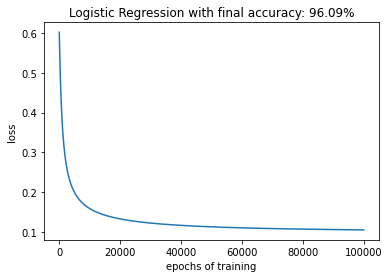

In [9]:
#------------------------------------------------
# Initiate, Train and Evaluate our model
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])

model            = LogisticRegression(hyperparams['input_dim'], hyperparams['output_dim'])
model, losses    = train_model( model, x, y, hyperparams)
accuracy         = eval_model(  model, x, y, hyperparams)

#------------------------------------------------
# Plot the performance
#------------------------------------------------
plt.plot(losses)
plt.xlabel('epochs of training')
plt.ylabel('loss')
plt.title('Logistic Regression with final accuracy: ' + str(100*accuracy)[0:5] + '%')

<br><br> The above plot shows the loss as a function of the epochs of training. It seems that most of the gains occur after the first 10,000 or so epochs, and then the loss improves only slightly thereafter. We can sanity check these results by looking at the paramter values to make sure they are close to the values we were seeing in Part 2 (recall that the paramter values in that case were -12 and 1.7)

In [10]:
#------------------------------------------------
# Print the Paramters
#------------------------------------------------
print('----------------------------')
print('Model Parameters:')
print('----------------------------')
for param in model.parameters():    
    print(param.detach().squeeze().numpy())

----------------------------
Model Parameters:
----------------------------
1.5126332
-11.088784


<br><br> Those paramter values are pretty close, verifying that we trained this Logistic Regression model correctly!

### Feed Forward Neural Networks

Now let's try training a multi-layer neural network, also known as a feed-forward network. But in order for us to appriciate their abilities, let's use a slightly more challenging dataset; something where we know the network should beat the logistic regression model. I've created one such dummy dataset below:

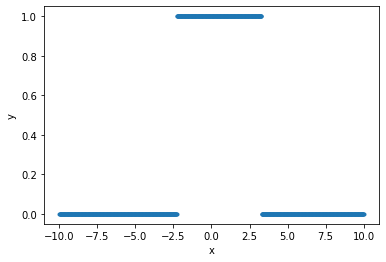

In [11]:
#------------------------------------------------
# Creating a Dummy Dataset For Neural Network Training
#------------------------------------------------
x = np.linspace(-10,10,1000) 
y = 1- np.round(1/ (1+ np.exp(-x * x + 2 + x + 5 + np.random.normal())))
plt.plot(x,y,'.'); plt.xlabel('x'); plt.ylabel('y'); plt.show()

<br><br> A a glance, you can tell that a sigmoid is not a goot fit for that data. But neural networks are flexible function approximators, so, as long as we add enough **nodes** and **layers**, we should should be able to fit data well using a neural network. Let's try both models and compare their loss.

To begin, we'll need to convert the data we just created into torch's tensor format.

In [12]:
#------------------------------------------------
# Convert our data to torch format
#------------------------------------------------
x = torch.tensor(x) 
x = x.to(torch.float)
x = x.view(np.shape(x)[0], 1)

y = torch.tensor(y)
y = y.to(torch.float)
y = y.view(np.shape(y)[0] , 1)

<br><br> Next, let's define a new model called ShallowNet that consists of 4 layers: 1 input, 2 middle layers (also known as hidden layers) and an output layer:

In [13]:
#------------------------------------------------
# Define a Model
#------------------------------------------------
class ShallowNet(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):  
        # Inherited from the parent class nn.Module
        super(ShallowNet, self).__init__()                       
        self.sigmoid = nn.Sigmoid()                         # sigmoid activation
        self.fc1     = nn.Linear(input_dim, hidden_size)    # 1st Full-Connected Layer: 1 (input data) -> # (hidden_size)
        self.fcm     = nn.Linear(hidden_size, hidden_size)  # 2nd Full-Connected Layer: 2 (hidden_size) -> # (hidden node)
        self.fcm2    = nn.Linear(hidden_size, hidden_size)  # 3rd Full-Connected Layer: 3 (hidden_size) -> # (hidden node)
        self.fc2     = nn.Linear(hidden_size, output_dim)   # 4rd Full-Connected Layer: 4 (hidden node) -> 1 (output class)
    
    # Forward pass: stacking each layer together
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fcm(out)
        out = self.sigmoid(out)
        out = self.fcm2(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

<br><br> Now, just as we did before, let's train the models using the `train_model` and `eval_model` functions we wrote earlier:

In [14]:
#------------------------------------------------
# Define model hyperparamters 
#------------------------------------------------
hyperparams = {}
hyperparams['input_dim']      = 1             # Number of columns in the input data 'x'
hyperparams['output_dim']     = 1             # Number of targets you want to predict 'y'
hyperparams['random_seed']    = 5           # Random seed - this will impact initial weights.
hyperparams['loss_function']  = nn.BCELoss()  # loss function  (Binary Cross Entropy Loss = BCELoss )
hyperparams['learning_rate']  = 0.1          # learning rate for the optimizer
hyperparams['epochs']         = 15000         # number of runs over the training data

#------------------------------------------------
# Train a Logistic Regression
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = LogisticRegression(hyperparams['input_dim'], hyperparams['output_dim'])
model, losses    = train_model( model, x, y, hyperparams)
accuracy1        = eval_model(  model, x, y, hyperparams)

#------------------------------------------------
# Train a Shallownet
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = ShallowNet(hyperparams['input_dim'], 2, hyperparams['output_dim'])
model, losses2   = train_model( model, x, y, hyperparams)
accuracy2        = eval_model(  model, x, y, hyperparams)

<br><br> And finally, let's compare the fit of the two models according to their loss

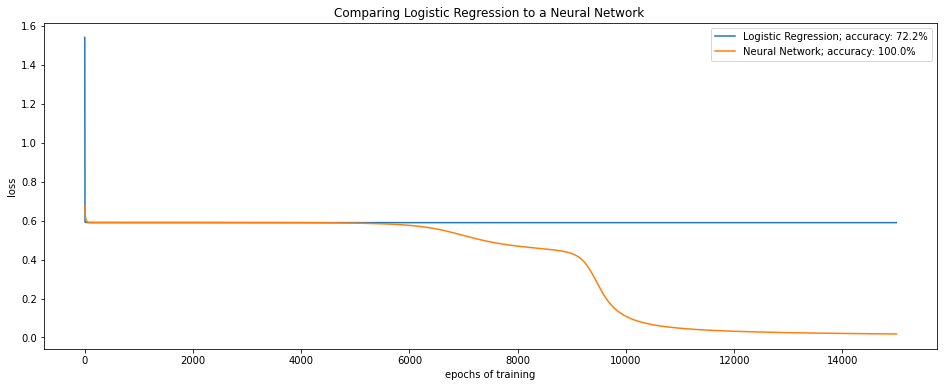

In [15]:
plt.figure(figsize = (16,6))
#------------------------------------------------
# Plot the performance
#------------------------------------------------
plt.plot(losses,  label='Logistic Regression; accuracy: ' + str(accuracy1 * 100)[0:5] + '%')
plt.plot(losses2, label='Neural Network; accuracy: ' + str(accuracy2 * 100) + '%')
plt.xlabel('epochs of training'); plt.ylabel('loss')
plt.title('Comparing Logistic Regression to a Neural Network ')
plt.legend()
plt.show()

<br><br> Notice that for the first 5,000 or so epochs, the loss of the `LogisticRegression` and the `ShallowNet` are almost identical. It's not until much later in the training process that the network finally pulls ahead. 

The reason for this behavior is because, unlike the logistic regression, the loss function of the nural network is no longer that smooth grid we saw earlier in the tutorial; indeed, the relationship between the loss and paramters for the neural net is more like a mountain range - there are many peaks and valley in the loss with respect to the parameter values. 

The consequence of this non-convex loss function is that the network may spend a lot of time descending into a long valley with a lower gradient or may even fail to converge to a good solution if the the initialization of it's paramters were unlucky. Let's demonstrate this by running the exact same function, but only changing the value of the random number generator:

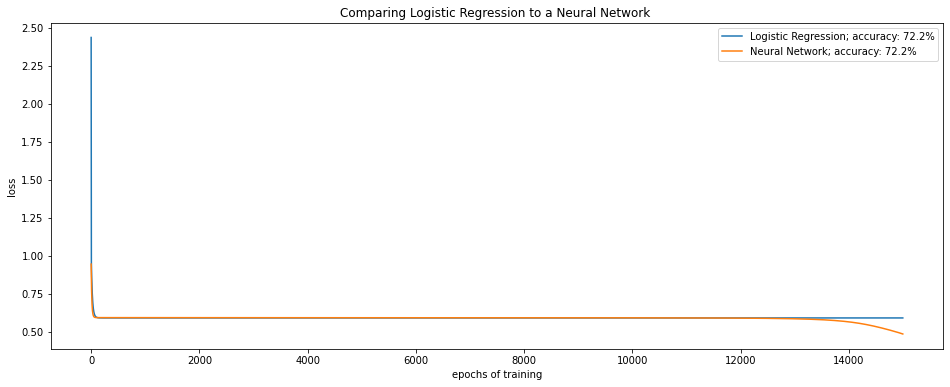

In [17]:
#------------------------------------------------
# Define model hyperparamters 
#------------------------------------------------
hyperparams['random_seed']    = 99             # Random seed - this will impact initial weights.

#------------------------------------------------
# Train a Logistic Regression
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = LogisticRegression(hyperparams['input_dim'], hyperparams['output_dim'])
model, losses    = train_model( model, x, y, hyperparams)
accuracy1        = eval_model(  model, x, y, hyperparams)

#------------------------------------------------
# Train a Shallownet
#------------------------------------------------
torch.manual_seed(hyperparams['random_seed'])
model            = ShallowNet(hyperparams['input_dim'], 2, hyperparams['output_dim'])
model, losses2   = train_model( model, x, y, hyperparams)
accuracy2        = eval_model(  model, x, y, hyperparams)

plt.figure(figsize = (16,6))
#------------------------------------------------
# Plot the performance
#------------------------------------------------
plt.plot(losses,  label='Logistic Regression; accuracy: ' + str(accuracy1 * 100)[0:5] + '%')
plt.plot(losses2, label='Neural Network; accuracy: ' + str(accuracy2 * 100) + '%')
plt.xlabel('epochs of training'); plt.ylabel('loss')
plt.title('Comparing Logistic Regression to a Neural Network ')
plt.legend()
plt.show()

<br><br> Do you see what I mean? The only thing that was changed between this run, and the previous example was the seed of the random number generator, which controls (among other things) the initial point from which we will start our gradient descent! This is critical for you to see because if your network's loss is not decreasing beyond that of a simple model (such as a logistic regression), it provides evidence of an unlucky starting position, or some other hyper-paramter issue. In practice, the way that you overcome this is by simply testing many settings of the hyper-parmaters, just like we did in part 1 of the tutorial when we were training the ElasticNet regularized logistic regression! 

<hr> 

## Learning Exercise 3: 
#### Worth 2/5 Points
#### A. Specify A Neural Classification Model
Using Pytorch, specify a neural network model that will map a sparse bag-of-words representation of the Rotton Tomatoes Movie Review Dataset from part 1 of the tutorial to the probability of the movie review being positive. It's up to you to choose the number of layers and the number of nodes; just recall that **deeper** networks are more flexible, but also trickier to train because their loss functions become more complex. The examples in the tutorial should be enough to accomplish this task, but [this online example](https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html) might also be helpful.

In [28]:
################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO DISCUSS YOUR RESULTS
################################################################################

<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

#### B. Train and Evaluate the Model
Train your Neural network on the `dataset['train']` partition of the data. At every epoch, evaluate the loss of the model on the `dataset['validation']`, `dataset['train']` and `dataset['test']`. Create a plot that compares the loss of the model on the three partitions and comment on any differences or trends you observe; Note that you may need to experiment with several settings of the hyper-paramters to get your model to fit effectively.


In [ ]:
from datasets import load_dataset
# Importing the Rotton Tomatoes Movie review dataset
dataset = load_dataset('rotten_tomatoes')

################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO DISCUSS YOUR RESULTS
################################################################################

<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

<h1><span style="color:red"> Self Assessment </span></h1>
Please provide an ssessment of how successfully you accomplished the learning exercises in this assignment according to the instruction provided; do not assign youself points for effort. This self assessment will be used as a starting point when I grade your assignments. Please note that if you over-estimate your grade on a given learning exercise, you will face a 50% penalty on the total points granted for that exercise. If you underestimate your grade, there will be no penalty.

* Learning Exercise: 
    * <span style="color:red">X</span>/2 points